> Note: All code used in this notebook is contained in the [notebooks/beaconrunner](https://github.com/barnabemonnot/beaconrunner/tree/master/notebooks/beaconrunner) folder of the Beacon runner repo, and does not use current eth2.0 specs. Most of the content here remains applicable.

Our goal in this document is to get the specs running in a [cadCAD](https://github.com/BlockScience/cadCAD) simulation environment, using the `BeaconState` object defined in the [eth2 specs](https://github.com/ethereum/eth2.0-specs/blob/dev/specs/phase0/beacon-chain.md). cadCAD is a cool new framework to simulate complex dynamics, in particular in stochastic environments. This makes it ideal to simulate the models of token economics and more generally any system that is controlled by state updates and user interactions. You can learn more about cadCAD by following [Markus Koch](https://twitter.com/markusbkoch)'s [tutorials](https://github.com/BlockScience/cadCAD/tree/master/tutorials), especially [part 5](https://github.com/BlockScience/cadCAD/blob/master/tutorials/robot-marbles-part-5/robot-marbles-part-5.ipynb) on using class objects as a state variable.

In this notebook, we present the dynamics of block proposers on the beacon chain first, to get a feel of how the chain evolves over time. Then, we introduce validation proper, where validators cast votes to finalise the chain. If we think in game-theoretic terms, here we really just want to understand the basic space of decision-making of the several players in the protocol, as well as the information available to them when such decisions are made. We simplify the presentation by assuming there is no latency and all validators can always access the latest state. A more detailed model will relax these assumptions. 

We'll introduce basic building blocks of eth2 as we go along, but there is a ton of resources out there to learn more ([Ben Edgington's portal](https://hackmd.io/@benjaminion/By6gV_dXS) is an excellent place to start for instance).

Let's start! We first need to load a bunch of stuff. Make sure you have cadCAD installed, pandas and all the fluff that comes with your favourite Python distribution. Alternatively, find a cool guide [here](https://community.cadcad.org/t/python-newbies-setup-for-cadcad/101) to do all that painlessly.

In [1]:
from constants import SECONDS_PER_DAY, GENESIS_EPOCH, SLOTS_PER_HISTORICAL_ROOT, MAX_VALIDATORS_PER_COMMITTEE
from specs import (
    BeaconState, BeaconBlock, BeaconBlockHeader, BeaconBlockBody, SignedBeaconBlock,
    Deposit, DepositData, Checkpoint, AttestationData, Attestation,
    initialize_beacon_state_from_eth1, get_block_root, get_block_root_at_slot,
    process_slots, process_block,
    get_current_epoch, get_previous_epoch, compute_start_slot_at_epoch,
    get_total_active_balance, get_committee_assignment, get_active_validator_indices, is_valid_genesis_state
)
from ssz_impl import (hash_tree_root, signing_root)
from ssz_typing import Bitlist
from hash_function import hash
from eth2 import eth_to_gwei

import secrets

# cadCAD configuration modules
from cadCAD.configuration.utils import config_sim
from cadCAD.configuration import Experiment

# cadCAD simulation engine modules
from cadCAD.engine import ExecutionMode, ExecutionContext
from cadCAD.engine import Executor

from cadCAD import configs

import pandas as pd

## Genesis state and genesis block

Dynamical systems are usually rather compact to define. We need at the very least two things:

- Some initial state.
- The dynamics, or how state evolves over time.

In this part we'll focus on the initial state. We create a dummy genesis state with a bunch of validators (10 of them) who deposit 32 ETH in the contract, the minimum required to start validating.

In [2]:
# Create an array of `Deposit` objects
def get_initial_deposits(n):
    return [Deposit(
        data=DepositData(
        amount=eth_to_gwei(32),
        pubkey=secrets.token_bytes(48))
    ) for i in range(n)]

In [3]:
hey = "hello"
block_hash = hash(hey.encode("utf-8"))
eth1_timestamp = 1578009600

genesis_state = initialize_beacon_state_from_eth1(block_hash, eth1_timestamp, get_initial_deposits(10))
print(genesis_state.slot)

0


Let's check the current _active_ balance! (returned here in ETH). We have 10 validators so this should tally up to 320.

In [4]:
get_total_active_balance(genesis_state) / 1000000000

320.0

In the specs, the first block is not proposed by a validator but obtained from the genesis state. We define a function to process the genesis block from the genesis state.

In [5]:
def process_genesis_block(genesis_state):
    genesis_block = SignedBeaconBlock(
        message=BeaconBlock(
            state_root=hash_tree_root(genesis_state),
            parent_root=hash_tree_root(genesis_state.latest_block_header)
        )
    )
    process_block(genesis_state, genesis_block.message)
    
process_genesis_block(genesis_state)

In [6]:
genesis_state.latest_block_header

{'slot': 0, 'parent_root': b'NT\x80\xe9\xb7\xa5\x9a\xbc\xc6\x089\x00\x8fvY\\i\x07!s\xf4E\xa6\x1b\xffA\x00\x97\xda9\x9a\xe8', 'state_root': b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00', 'body_root': b'u\x95v\xf3\x1dU\x93\x98\xc9\x0b\xea\x13\x92\xe5#\xd1]\xf6m\xf2\x8d\xb5\xb0~O\xc4\x01\xbd|\xcb\xc7>'}

Finally, set the genesis state as the initial condition to our cadCAD execution.

In [7]:
initial_conditions = {
    'beacon_state': genesis_state
}

## State evolution with block proposals

We move on to defining the dynamics. Simple dynamical systems follow some rules to update their state, e.g., the orbits of planets are given by laws derived from attraction. More complex systems are _controlled_: decisions made by agents in the system influence the state evolution.

In our setting, these agents are validators. State evolution is governed by the rules of the virtual machine, while validators get to decide on blocks and transactions. The resulting state is a combination of agent decisions and state updates. How validators make these decisions is embodied by _policy functions_: given a state, make a decision.

In eth2, time is subdivided in _epochs_, themselves divided in _slots_. At most one block should be proposed at each slot, while accounting for votes and doling out rewards and penalties is done at the end of each epoch. Note that to speed things up in this document, we set the `SLOTS_PER_EPOCH` constant to 4 in the `constants.py` file. This is 8x faster than the value in the current specs. (ICO when???)

We now define policies and state updates to run the simulation. Let's take a moment to understand how state transitions work in the [eth2 specs](https://github.com/ethereum/eth2.0-specs/blob/dev/specs/phase0/beacon-chain.md), with notation we introduce here to clarify the different states.

1. Given a slot $s$, define $\omega^-[s]$ as the _pre-state_ of $s$. Once a block $b_s$ is proposed for slot $s$, the specs-defined `process_block` obtains state $\omega^+[s]$ from $\omega^-[s]$ and $b_s$.
2. To go from $\omega^+[s]$ to $\omega^-[s+1]$, the specs-defined `process_slots` caches the block root of $b_s$ and the state root. If $s+1$ is the first slot of a new epoch, `process_epoch` is called which checks for justification and finalisation of checkpoints as well as attribute rewards and punishments to active validators and process exits and new entries.
3. From $\omega^-[s+1]$, we repeat the first two steps.

Let's talk about the start of this process. The `genesis_state` object defined above really is $\omega^-[0]$. When we call `process_genesis_block`, we move to $\omega^+[0]$. This is the **initial condition** of our simulations.

In our simulation, we move the state ahead given a block $b_s$ for slot $s$ from $\omega^+[s-1]$ to $\omega^+[s]$. We will break it down in three steps:

1. **(State update)** Process slot `s-1`, moving from $\omega^+[s-1]$ to $\omega^-[s]$. If a block was proposed during slot $s-1$, the root of the block is cached in the `block_roots` attribute of $\omega^-[s]$, at index `s-1`. Otherwise, the root of the most recent block is cached. Additionally, if `s-1` is the last slot of an epoch, `process_epoch` is called.
2. **(Policy)** A policy for block proposers to propose a new block $b_s$ at slot $s$.
3. **(State update)** Process block $b_s$, taking $\omega^-[s]$ to $\omega^+[s]$.

Let's do this step by step:

### Process slot

The arguments of this function are given to us by the cadCAD execution environment. `s` holds the current state of the simulation, where `s['beacon_state']` returns the current beacon state. Remember that we had set the initial state $\omega^+[0]$ as the `beacon_state` attribute of the `initial_conditions` dictionary.

In [8]:
def state_update_slot(params, step, sL, s, _input):
    # Given state w+[s], transition to w-[s+1]
    
    # state is w+[s]
    state = s['beacon_state']
    
    process_slots(state, state.slot + 1)
    
    return ('beacon_state', state) # beacon state is now updated to 'state'. 

### Propose a block

We have more latitude to define what happens at this step. We can for instance make the difference between an honest validator who returns a block when they are the block proposer, given the most current state, and an offline validator who just does not produce anything. Given a state, each will return a different item.

In [9]:
def honest_block_proposal(state):
    # State is w-[s], block will be proposed for slot s
    
    # Later on, we populate the `BeaconBlockBody`. For now, our validators merely produce empty blocks.
    beacon_block_body = BeaconBlockBody()
    
    beacon_block = BeaconBlock(
        slot=state.slot,
        # the parent root is accessed from the state
        parent_root=get_block_root_at_slot(state, state.slot-1),
        body=beacon_block_body
    )
    signed_beacon_block = SignedBeaconBlock(message=beacon_block)
    
    print("honest propose a block for slot", state.slot)
    return signed_beacon_block

In [10]:
def offline_block_proposal(state):
    print("offline propose nothing for slot", state.slot)
    return None

We now define the policy function of step 2, again using the arguments that the cadCAD environment gives us. In this simulation, we'll assume that an honest and an offline validator propose in turn, so we only have blocks on even slots.

In [11]:
# policy function
def propose_block(params, step, sL, s):
    # Given state w-[s], propose a block for slot s
    
    # `state` is w-[s]
    state = s['beacon_state']
    
    if state.slot % 2 == 0:
        block = honest_block_proposal(state)
    else:
        block = offline_block_proposal(state)
        
    return {'block': block }

### Process the block

Given a block, we can run the state transition by calling `process_block`. We get the block proposed in step 2 as the `block` attribute of `_input`.

In [12]:
def state_update_block(params, step, sL, s, _input):
    state = s['beacon_state']
    block = _input['block']
    
    if block is None:
        # No change to the state
        return ('beacon_state', state)
    
    # Otherwise we process the block first and return the state
    process_block(state, block.message)
    
    return ('beacon_state', state)

## Putting it all together

The previous three steps are recorded in the `block_proposal_psub` array. `psub` stands for _partial state updates blocks_, the building blocks of a cadCAD simulation.

In [13]:
block_proposal_psub = [
    {
        'policies': {
        },
        'variables': {
            'beacon_state': state_update_slot # step 1
        }
    },
    {
        'policies': {
            'action': propose_block # step 2
        },
        'variables': {
            'beacon_state': state_update_block # step 3
        }
    }
]

### Execution

We first give parameters to run the simulation. The `T` variable corresponds to slots in the beacon chain execution.

In [14]:
simulation_parameters = {
    'T': range(15), # number of time steps
    'N': 1, # number of repetitions (Monte Carlo runs)
    'M': {} # parameter sweep (iterating over different paramters)
}

We set up our cadCAD execution with the pieces we created above.

In [15]:
experiment = Experiment()
experiment.append_configs(
    initial_state = initial_conditions,
    partial_state_update_blocks = block_proposal_psub,
    sim_configs = simulation_parameters
)

Run it! (This may take some time)

In [16]:
exec_mode = ExecutionMode() #
exec_context = ExecutionContext() # how to run simulation (single vs. multi threaded, etc.)
simulation = Executor(exec_context=exec_context, configs=configs)
# The `execute()` method returns a tuple; its first elements contains the raw results
raw_result, tensor, sessions = simulation.execute() 
df = pd.DataFrame(raw_result)

Initializing configurations: 100%|██████████| 1/1 [00:00<00:00, 183.69it/s]
                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: local_proc
Configuration Count: 1
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (15, 0, 1, 1)
Execution Method: local_simulations
SimIDs   : [0]
SubsetIDs: [0]
Ns       : [0]
ExpIDs   : [0]
Execution Mode: single_threaded

offline propose nothing for slot 1
honest propose a block for slot 2
offline propose nothing for slot 3
START PROCESS EPOCH 0
not processing justification and finalization
END PROCESS EPOCH
honest propose a block for slot 4
offline propose nothing for slot 5
honest propose a block for slot 6
offline propose nothing for slot 7
START PROCESS EPOCH 1
not processing justification and finalization
END PROCESS EPOCH
honest propose a block for slot 8
offline pro

In [17]:
df.head()

,beacon_state,simulation,subset,run,substep,timestep
0,BeaconState\n genesis_time: 1578182400\n slo...,0,0,1,0,0
1,BeaconState\n genesis_time: 1578182400\n slo...,0,0,1,1,1
2,BeaconState\n genesis_time: 1578182400\n slo...,0,0,1,2,1
3,BeaconState\n genesis_time: 1578182400\n slo...,0,0,1,1,2
4,BeaconState\n genesis_time: 1578182400\n slo...,0,0,1,2,2


The historical sequence of states is held in the `df` dataframe, let's take a look.

In [18]:
df['latest_block_root'] = df.beacon_state.apply(lambda state: hash_tree_root(state.latest_block_header).hex()[0:6])
df.iloc[:,2:5]

,subset,run,substep
0,0,1,0
1,0,1,1
2,0,1,2
3,0,1,1
4,0,1,2
5,0,1,1
6,0,1,2
7,0,1,1
8,0,1,2
9,0,1,1


We give the last few bytes of the latest block header root in the state. Timesteps virtually represent slots of the beacon chain. For each timestep, we have two substeps since we have two partial state update blocks.

- At timestep `s` and substep 1, the state is $\omega^-[s]$.
- At timestep `s` and substep 2, the state is $\omega^+[s]$.

_Note:_ The block root does not change during odd timesteps. This is because we have offline validators who do not propose blocks then.

_Also note:_ The latest block root in substep 2 of even timesteps is unique. Before we process the slot, the `state_root` attribute of the latest block header saved in the state is not set. When we process the slot, this state root is set and this changes the `latest_block_root` hash.

Finally, we can check whether checkpoints (i.e., blocks between epochs) are being finalised, which is why we care about the beacon chain in the first place.

In [19]:
df.iloc[30]['beacon_state'].finalized_checkpoint

{'epoch': 0, 'root': b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00'}

Nope! The last finalised checkpoint is still the genesis block. The blocks are empty since we restricted validators to their block proposer roles. Time to have them vote on the canonical chain and start finalising!

## Once more with attestations

We create new policies to make validators attest on the blocks of the beacon chain. Attestations are "votes" in the FFG gadget, committing to checkpoints and beacon chain blocks. _All_ active validators are called on to produce one attestation during each epoch. Each validator is assigned to _one_ slot to make the attestation at, preferably right after they have received the block proposed for that slot.

So attestations should contain:
- A _source_ attribute: the last justified checkpoint the validator knows about.
- A _target_ attribute: the last non-justified checkpoint the validator knows about.
- A _head_ attribute: what the validator sees as the current tip of the beacon chain, preferably the block proposed for their assigned slot.
- A _slot_ attribute: the slot assigned to the validator.

Admittedly, we are cheating a bit here. Since we assume our validators are honest and there is no latency, they are instantly up-to-date with the latest chain state, so we can use the `BeaconState` attributes to form validator attestations. In reality, validators should run the fork choice to decide which is the head of the beacon chain.

We start at some state $\omega^+[s-1]$, i.e., the post-state of slot $s-1$.

1. **(State update)** We move the state from $\omega^+[s-1]$ to $\omega^-[s]$.
2. **(Policy)** Validators at state $\omega^-[s]$ make attestations for slot $s-1$. These attestations contain a source and target for their FFG vote and the head of the chain according to their view of the beacon chain (in this case, $b_{s-1}$).
3. **(State update)** These attestations are kept in the simulation state space as `current_slot_attestations`.
4. **(Policy)** Someone proposes a block $b_s$ at slot $s$. Note that $b_s$ contains attestations made by validators in committees at slot $s-1$, which are kept in `current_slot_attestations`.
5. **(State update)** The state transitions to $\omega^+[s]$ when the block is processed.

### Process slot

We already have a state transition function for that, our previously defined `state_update_slot`.

### Attestation policy

Let's focus on the new step here, step \#2. We first need to create honest attestations from validators.

In [14]:
def honest_attest(state, validator_index):
    # Given state w-[s], validators in committees of slot `s-1` form their attestations
    # In several places here, we need to check whether `s` is the first slot of a new epoch.
    
    current_epoch = get_current_epoch(state)
    previous_epoch = get_previous_epoch(state)
    
    # Since everyone is honest, we can assume that validators attesting during some epoch e
    # choose the first block of e as their target, and the first block of e-1 as their source
    # checkpoint.
    #
    # So let's assume the validator here is making an attestation at slot s in epoch e:
    #
    # - If the `state` variable is at epoch e, then the first block of epoch e-1 is
    # a checkpoint held in `state.current_justified_checkpoint`.
    # The target checkpoint root is obtained by calling
    # `get_block_root(state, current_epoch)` (since current_epoch = e).
    #
    # - If the `state` variable is at epoch e+1, then the first block of epoch e-1
    # is a checkpoint held in `state.previous_justified_checkpoint`,
    # since in the meantime the first block of e was justified.
    # This is the case when s is the last slot of epoch e.
    # The target checkpoint root is obtained by calling
    # `get_block_root(state, previous_epoch)` (since current_epoch = e+1).
    #
    # ... still here?
    
    # If `state` is already at the start of a new epoch e+1
    if state.slot == compute_start_slot_at_epoch(current_epoch):
        # `committee_slot` is equal to s-1
        (committee, committee_index, committee_slot) = get_committee_assignment(
            state, previous_epoch, validator_index
        )
        
        # Since we are at state w-[s], we can get the block root of the block at slot s-1.
        block_root = get_block_root_at_slot(state, committee_slot)
        
        src_checkpoint = Checkpoint(
            epoch=state.previous_justified_checkpoint.epoch,
            root=state.previous_justified_checkpoint.root
        )
        
        tgt_checkpoint = Checkpoint(
            epoch=previous_epoch,
            root=get_block_root(state, previous_epoch)
        )
    # Otherwise, if `state` is at epoch e
    else:
        # `committee_slot` is equal to s-1
        (committee, committee_index, committee_slot) = get_committee_assignment(
            state, current_epoch, validator_index
        )
        
        # Since we are at state w-[s], we can get the block root of the block at slot s-1.
        block_root = get_block_root_at_slot(state, committee_slot)
        
        src_checkpoint = Checkpoint(
            epoch=state.current_justified_checkpoint.epoch,
            root=state.current_justified_checkpoint.root
        )
        
        tgt_checkpoint = Checkpoint(
            epoch=current_epoch,
            root=get_block_root(state, current_epoch)
        )
        
    att_data = AttestationData(
        index = committee_index,
        slot = committee_slot,
        beacon_block_root = block_root,
        source = src_checkpoint,
        target = tgt_checkpoint
    )
    
    print("attestation for source", src_checkpoint.epoch, "and target", tgt_checkpoint.epoch)
    
    # For now we disregard aggregation of attestations.
    # Some validators are chosen as aggregators: they take a bunch of identical attestations
    # and join them together in one object,
    # with `aggregation_bits` identifying which validators are part of the aggregation.
    committee_size = len(committee)
    index_in_committee = committee.index(validator_index)
    aggregation_bits = Bitlist[MAX_VALIDATORS_PER_COMMITTEE](*([0] * committee_size))
    aggregation_bits[index_in_committee] = True # set the aggregation bits of the validator to True
    attestation = Attestation(
        aggregation_bits=aggregation_bits,
        data=att_data
    )
    
    return attestation

We can use this `honest_attest` function in our policy function for step \#2, `honest_attest_policy`.

In [15]:
def honest_attest_policy(params, step, sL, s):
    # Collect all attestations formed for slot s-1.
    
    # `state` is at w-[s]
    state = s['beacon_state']
    current_epoch = get_current_epoch(state)
    previous_epoch = get_previous_epoch(state)
    
    # `validator_epoch` is the epoch of slot s-1.
    # - If the state is already ahead by one epoch, this is given by `previous_epoch`
    # - Otherwise it is `current_epoch`
    if state.slot == compute_start_slot_at_epoch(current_epoch):
        validator_epoch = previous_epoch
    else:
        validator_epoch = current_epoch
        
    active_validator_indices = get_active_validator_indices(state, validator_epoch)
    slot_attestations = []
    
    for validator_index in active_validator_indices:
        # For each validator, check which committee they belong to
        (committee, committee_index, committee_slot) = get_committee_assignment(
            state, validator_epoch, validator_index
        )
        
        # If they belong to a committee attesting for slot s-1, we ask them to form an attestation
        # using `honest_attest` defined above.
        if committee_slot+1 == state.slot:
            print("validator attesting", validator_index, "for slot", committee_slot)
            attestation = honest_attest(state, validator_index)
            slot_attestations.append(attestation)
            
    return({ 'slot_attestations': slot_attestations })

### Keep attestations in state

Step \#3 is easily handled with one single state update.

In [16]:
def update_current_slot_attestations(params, step, sL, s, _input):
    # Take the output of `honest_attest_policy` and set it as `current_slot_attestations`
    return('current_slot_attestations', _input['slot_attestations'])

### Block proposal policy

We must update our block proposal policy to include latest attestations. This time, we do not include offline block proposers.

In [17]:
def honest_block_proposal(state, attestations):
    # State is w-[s], block will be proposed for slot s
    
    beacon_block_body = BeaconBlockBody(
        attestations=attestations
    )
    
    beacon_block = BeaconBlock(
        slot=state.slot,
        # the parent root is accessed from the state
        parent_root=get_block_root_at_slot(state, state.slot-1),
        body=beacon_block_body
    )
    signed_beacon_block = SignedBeaconBlock(message=beacon_block)
    z
    print("honest propose a block for slot", state.slot)
    return signed_beacon_block

In [18]:
def propose_block(params, step, sL, s):
    # Given state w-[s], propose a block for slot s
    
    # `state` is w-[s]
    state = s['beacon_state']
    # We get the output of our honest attestation policy
    attestations = s['current_slot_attestations']
    
    block = honest_block_proposal(state, attestations)
        
    return ({ 'block': block })

### Process block

We also have a state update for this step, `state_update_block`, which we do not need to change.

### Simulation time!

Our PSUB array becomes:

In [19]:
block_attestation_psub = [
    # Step 1
    {
        'policies':{
        },
        'variables': {
            'beacon_state': state_update_slot
        }
    },
    # Step 2+3
    {
        'policies': {
            'action': honest_attest_policy
        },
        'variables': {
            'current_slot_attestations': update_current_slot_attestations
        }
    },
    # Step 4+5
    {
        'policies': {
            'action': propose_block
        },
        'variables': {
            'beacon_state': state_update_block
        }
    }
]

We need to change our initial conditions to add the `current_slot_attestations` state attribute, which starts out empty. To keep the overhead low, we set a low number of validators and run the simulation for 20 slots.

In [20]:
%%capture

num_validators = 10

genesis_state = initialize_beacon_state_from_eth1(
    block_hash, eth1_timestamp, get_initial_deposits(num_validators)
)

initial_conditions = {
    'beacon_state': genesis_state,
    'current_slot_attestations': []
}

simulation_parameters = {
    'T': range(20),
    'N': 1,
    'M': {}
}

We define the configuration object again, and run our simulation.

In [21]:
# configure cadCAD
experiment = Experiment()
experiment.append_configs(
    initial_state = initial_conditions,
    partial_state_update_blocks = block_attestation_psub,
    sim_configs = simulation_parameters
)

Here we leave the execution trace visible. Use a `%%capture` directive at the top of the following cell to hide it.

In [22]:
# execute cadCAD
exec_mode = ExecutionMode() #
exec_context = ExecutionContext() # how to run simulation (single vs. multi threaded, etc.)
simulation = Executor(exec_context=exec_context, configs=configs)
# The `execute()` method returns a tuple; its first elements contains the raw results
raw_result, tensor, sessions = simulation.execute() 
df = pd.DataFrame(raw_result)

Initializing configurations: 100%|██████████| 1/1 [00:00<00:00, 181.78it/s]
                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: local_proc
Configuration Count: 1
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (20, 0, 1, 2)
Execution Method: local_simulations
SimIDs   : [0]
SubsetIDs: [0]
Ns       : [0]
ExpIDs   : [0]
Execution Mode: single_threaded

validator attesting 3 for slot 0
attestation for source 0 and target 0
validator attesting 5 for slot 0
attestation for source 0 and target 0
honest propose a block for slot 1
if-statement: target epoch: 0, source epoch: 0, current_justified_checkpoint epoch: 0, previous_justified_checkpoint epoch: 0
if-statement: target epoch: 0, source epoch: 0, current_justified_checkpoint epoch: 0, previous_justified_checkpoint epoch: 0
validator attesting 0 for slot 

Let's check the dataframe to make sure our state updates are correct. Since we have several partial updates blocks, we will have several substeps at each timestep. We give the length of the number of attestations in column `num_attestations`. They add up to 10 over each epoch, as we have 10 validators.

In [23]:
df

,beacon_state,current_slot_attestations,simulation,subset,run,substep,timestep
0,BeaconState\n genesis_time: 1578182400\n slo...,[],0,0,1,0,0
1,BeaconState\n genesis_time: 1578182400\n slo...,[],0,0,1,1,1
2,BeaconState\n genesis_time: 1578182400\n slo...,[Attestation\n aggregation_bits: Bitlist[bool...,0,0,1,2,1
3,BeaconState\n genesis_time: 1578182400\n slo...,[Attestation\n aggregation_bits: Bitlist[bool...,0,0,1,3,1
4,BeaconState\n genesis_time: 1578182400\n slo...,[Attestation\n aggregation_bits: Bitlist[bool...,0,0,1,1,2
...,...,...,...,...,...,...,...
56,BeaconState\n genesis_time: 1578182400\n slo...,[Attestation\n aggregation_bits: Bitlist[bool...,0,0,1,2,19
57,BeaconState\n genesis_time: 1578182400\n slo...,[Attestation\n aggregation_bits: Bitlist[bool...,0,0,1,3,19
58,BeaconState\n genesis_time: 1578182400\n slo...,[Attestation\n aggregation_bits: Bitlist[bool...,0,0,1,1,20
59,BeaconState\n genesis_time: 1578182400\n slo...,[Attestation\n aggregation_bits: Bitlist[bool...,0,0,1,2,20


In [24]:
df['num_attestations'] = df.current_slot_attestations.apply(len)
df['epoch'] = df.beacon_state.apply(get_current_epoch)
df[df.substep == 1].head(20).iloc[:,3:8]

,subset,run,substep,timestep,num_attestations
1,0,1,1,1,0
4,0,1,1,2,2
7,0,1,1,3,3
10,0,1,1,4,2
13,0,1,1,5,3
16,0,1,1,6,2
19,0,1,1,7,3
22,0,1,1,8,2
25,0,1,1,9,3
28,0,1,1,10,2


We can check the balances of our validators.

In [25]:
df.iloc[60]['beacon_state'].balances

List[Gwei, 1099511627776](32014368415, 32014820963, 32014594689, 32014255278, 32014707826, 32014594689, 32014481552, 32014368415, 32014368415, 32014255278)

Note that they are getting rewarded for attesting correctly, with balances greater than the initial 32 ETH they started with, but some are more rewarded than others: this is the randomness of the block proposal. If you picked a low `num_validators`, you will notice that rewards are quite high. This is due to the variable rate of reward, which increases when the supply of validators is low. In practice, for 1,000,000 ETH at stake, we ought to have about 30,000 validators.

We can also check that we are finalising checkpoints.

In [26]:
df.iloc[60]['beacon_state'].finalized_checkpoint

{'epoch': 3, 'root': b'5\x95u*\'j\xa6"\x1a\xb1\xe8Z\xf1\x82\xdf4\x9e\xc5c\x15\xcc\xa6%\x12d\x17{\xff\xd8\xbc\xb7\x16'}

Indeed, the latest finalised checkpoint is at epoch 3!

Let's plot the total rewards given out to validators (the "issuance"). First we add a column to our dataframe holding the net profits from state balances.

In [27]:
df['total_balance'] = df.beacon_state.apply(
    lambda state: sum(state.balances) - eth_to_gwei(32 * num_validators)
)

In [28]:
%matplotlib inline

<AxesSubplot:xlabel='timestep'>

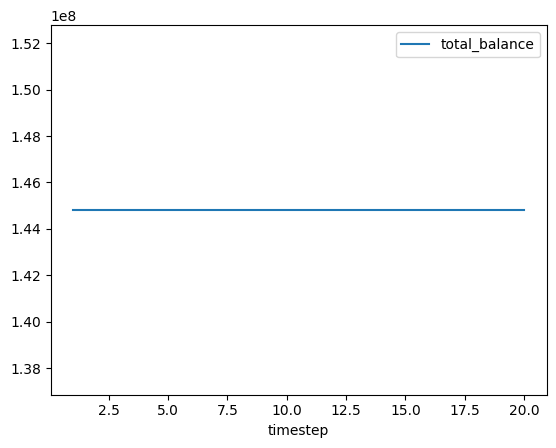

In [29]:
df[df.substep == 1].plot('timestep', 'total_balance')

It's kind of nice to see a small economy grow before your very eyes no? Like gardening.

Now how can we extend this model?

- We can define very specific validation behaviour and test what happens under different scenarios. Here we have focused on the "honest" behaviour, which is hopefully what validators on eth2 will follow. But hope is not enough, so much like [mining in Proof-of-Work, it remains to prove that good behaviour in the protocol exactly corresponds to rational behaviour in the _game_ defined by the protocol](https://hackingresear.ch/diaries/anarchy-creta).
- We can also tweak state updates to represent network delays and modify the information basis of validators, who we assumed here always have the latest data to make their attestations. This may be a good use case for cadCAD's support for stochastic simulations (where execution may depend on chance events).

Some efforts should also be spent making the simulation lighter to execute, so that larger models can be tested, including stochastic events using Monte-Carlo methods which require repeating executions a significant amount of times.

---

_Some other cool resources_:

- [Uniswap bonding curves with cadCAD](https://github.com/BlockScience/uniswap/blob/master/simplified-uniswap.ipynb)
- [Attestations and aggregators, a note by Hsiao-Wei Wang](https://notes.ethereum.org/@hww/aggregation)